In [20]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sbn

In [162]:
### Decide about the features to take according to the submission file
data = pd.read_csv('train_2011_2012_2013.csv',sep=';',usecols=['DATE','ASS_ASSIGNMENT','CSPL_RECEIVED_CALLS'])

In [163]:
d = pd.DataFrame(data.groupby(['DATE', 'ASS_ASSIGNMENT'])['CSPL_RECEIVED_CALLS'].sum())
d.reset_index(level=0, inplace=True)
d.reset_index(level=0, inplace=True)
data = d

In [4]:
subm_data = pd.read_table('submission.txt')

In [5]:
import time
data['time'] = data['DATE'].apply(lambda x: time.strptime(x, '%Y-%m-%d %H:%M:%S.000'))

In [6]:
data['day_week'] = data['time'].apply(lambda x: int(time.strftime("%w", x)))
data['day_month'] = data['time'].apply(lambda x: int(time.strftime("%d", x)))
data['month'] = data['time'].apply(lambda x: int(time.strftime("%m", x)))

### date scince epoch
data['time_absolut'] = data['time'].apply(time.mktime)

### New feature: hours since the start of the day
# data['hours'] = data['time'].apply(lambda x: float(time.strftime("%H", x))+np.sign(float(time.strftime("%M", x)))*0.5)

In [7]:
### New feature: hours since the start of the day
data['hours'] = data['time'].apply(lambda x: float(time.strftime("%H", x)))
data['year'] = data['time'].apply(lambda x: float(time.strftime("%Y", x)))

In [8]:
data['if_weekend'] = data['day_week'].apply(lambda x: 1 if x == 0 or x == 6 else 0)

In [9]:
data['if_night'] = data['hours'].apply(lambda x: 1 if x >= 7.5 and x <= 23.5 else 0) 

In [10]:
cats = data['ASS_ASSIGNMENT'].unique()
cat = cats[0]

In [11]:
import time
import xgboost as xgb
from tqdm import tqdm

models = {}
indexes = ['hours','year','month','day_month','day_week','if_weekend','if_night']
for cat in tqdm(cats):
    print(cat)
    print(len(data[data['ASS_ASSIGNMENT'] == cat]))
    start_time = time.time()
    X = data[data['ASS_ASSIGNMENT'] == cat][indexes]
    Y = data[data['ASS_ASSIGNMENT'] == cat]['CSPL_RECEIVED_CALLS']
    model = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=200, silent=True, 
                             objective='reg:linear', nthread=-1, gamma=0, min_child_weight=1,
                             max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1,
                             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
    model.fit(X,Y)
    models[cat] = model
    print("--- %s seconds ---" % (time.time() - start_time))

ImportError: No module named 'xgboost'

------ data analysis

In [12]:
cats = data['ASS_ASSIGNMENT'].unique()

In [13]:
cats

array(['Crises', 'Domicile', 'Gestion', 'Gestion - Accueil Telephonique',
       'Gestion Amex', 'Gestion Assurances', 'Gestion Clients',
       'Gestion Renault', 'Japon', 'Manager', 'Médical', 'Nuit', 'RENAULT',
       'Regulation Medicale', 'SAP', 'Services', 'Tech. Axa',
       'Tech. Inter', 'Téléphonie', 'Tech. Total', 'Mécanicien',
       'Gestion Relation Clienteles', 'CAT', 'Gestion DZ', 'CMS', 'RTC',
       'Prestataires', 'Evenements'], dtype=object)

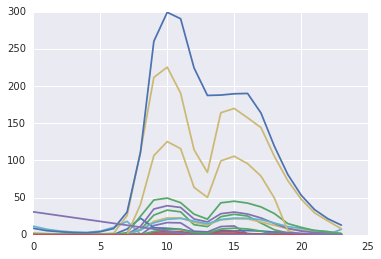

In [21]:
for cat in cats:
    data_cat = data[data['ASS_ASSIGNMENT'] == cat]
    day = 1
    data_cat = data_cat[data_cat['day_week'] == day]
    grouped = data_cat.groupby(['hours'])['CSPL_RECEIVED_CALLS'].mean()
    plt.plot(grouped)

In [15]:
data['time_absolut'].min(), data_cat['time_absolut'].max()

(1293836400.0, 1365373800.0)

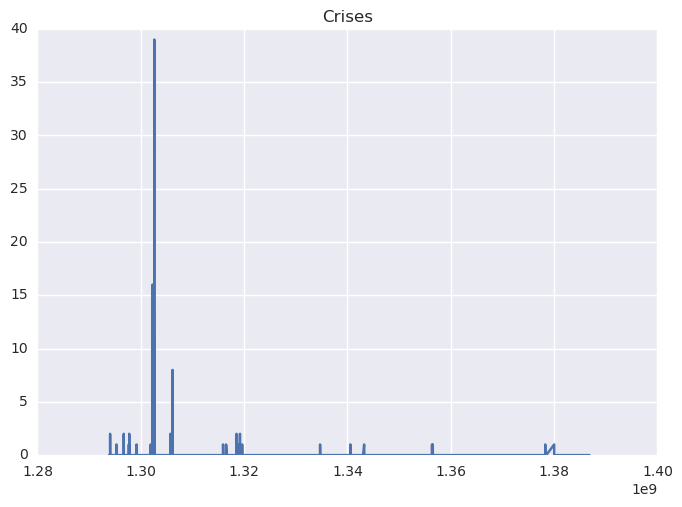

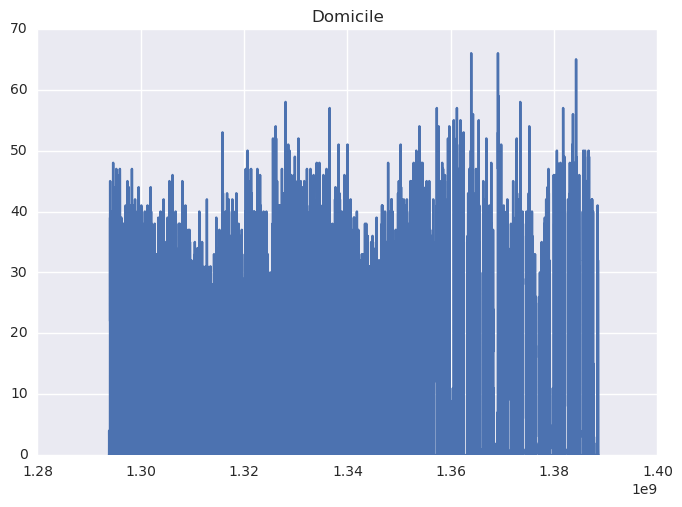

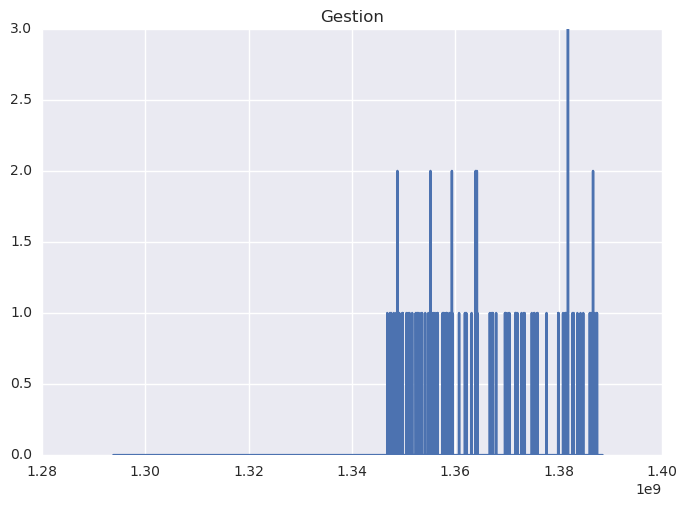

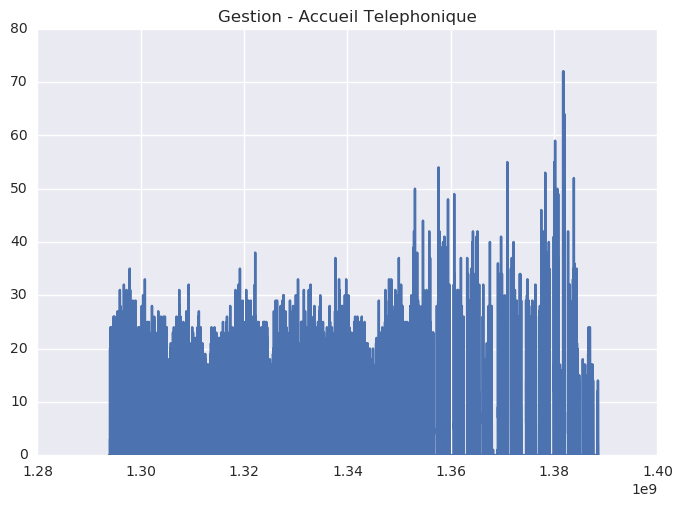

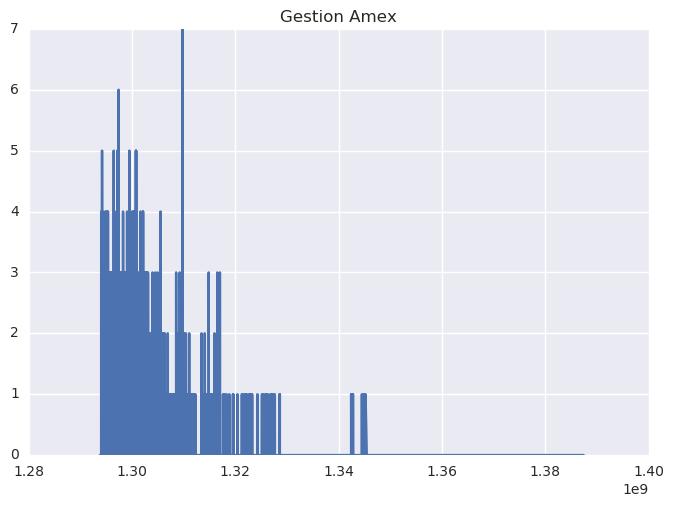

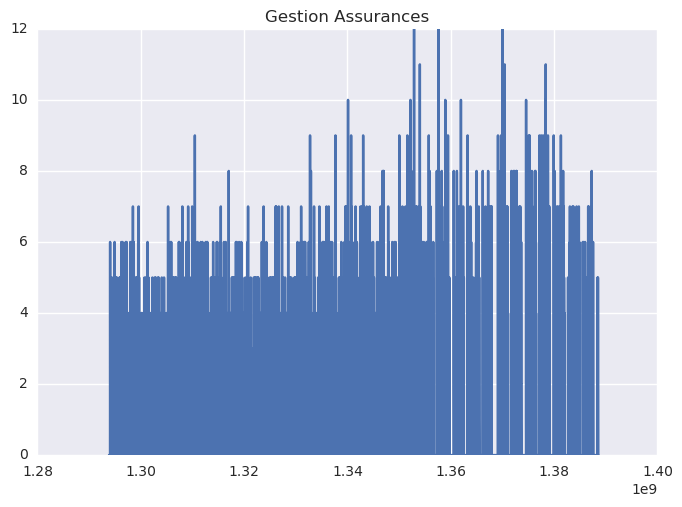

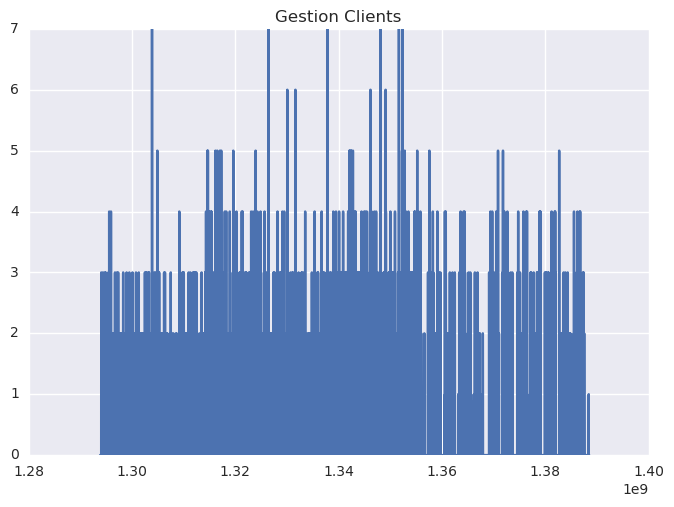

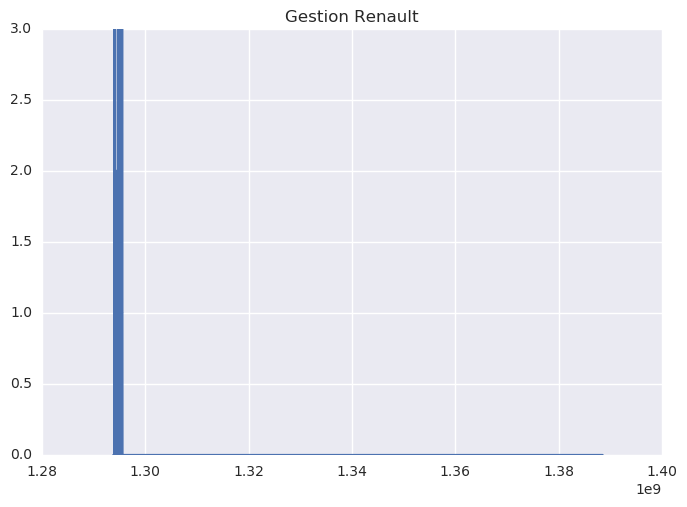

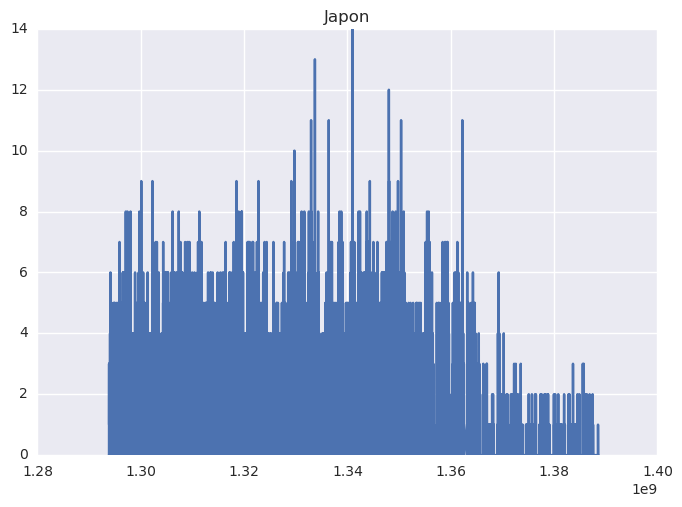

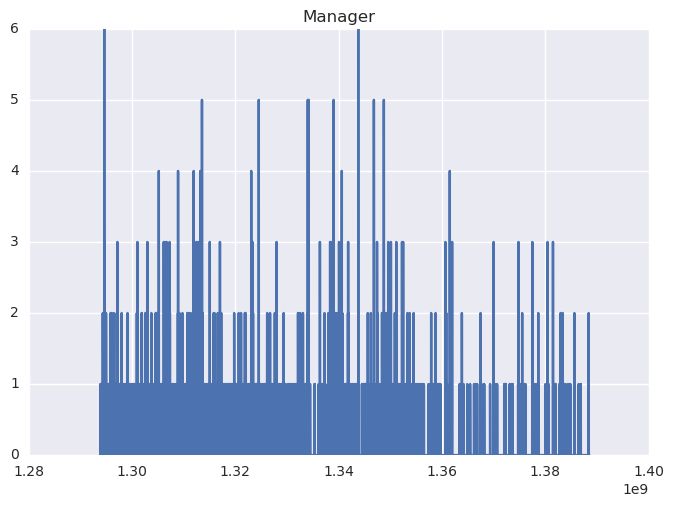

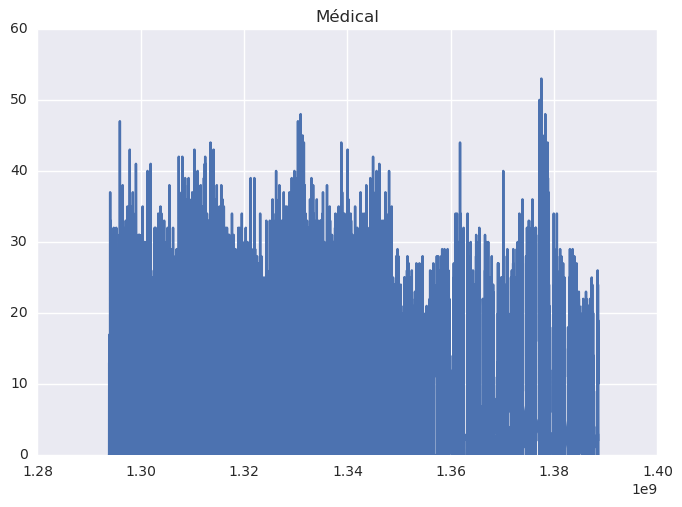

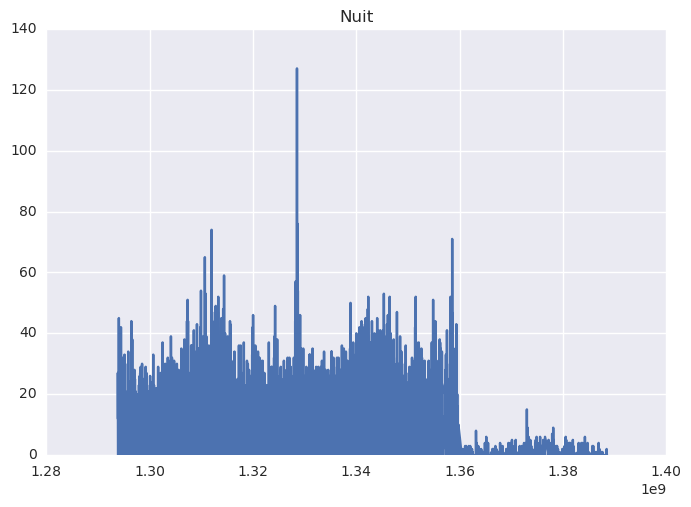

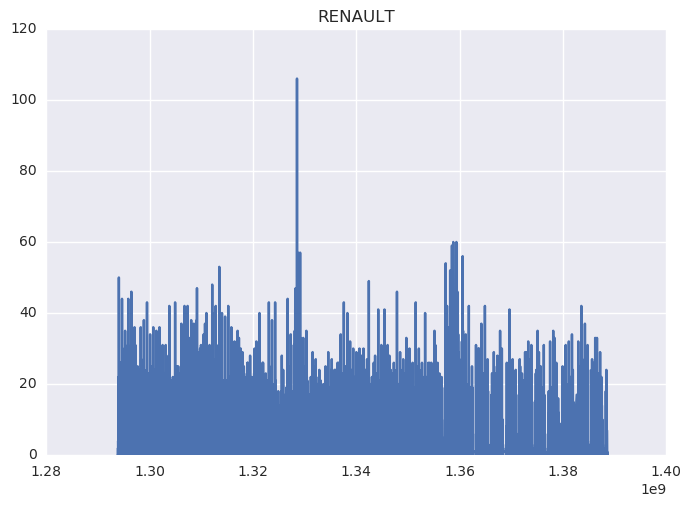

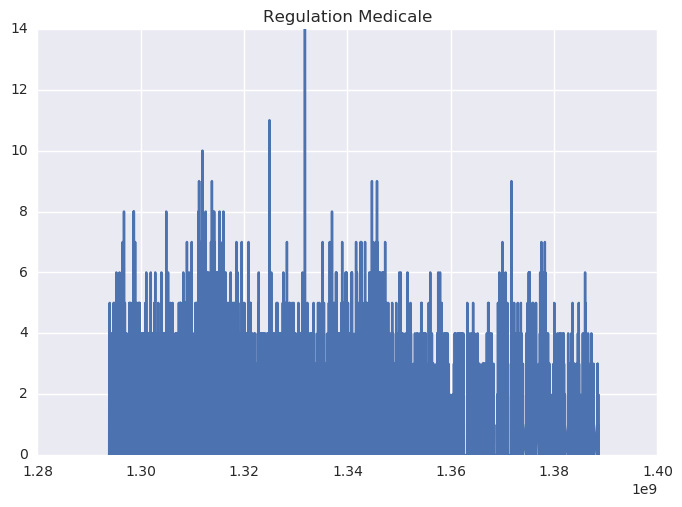

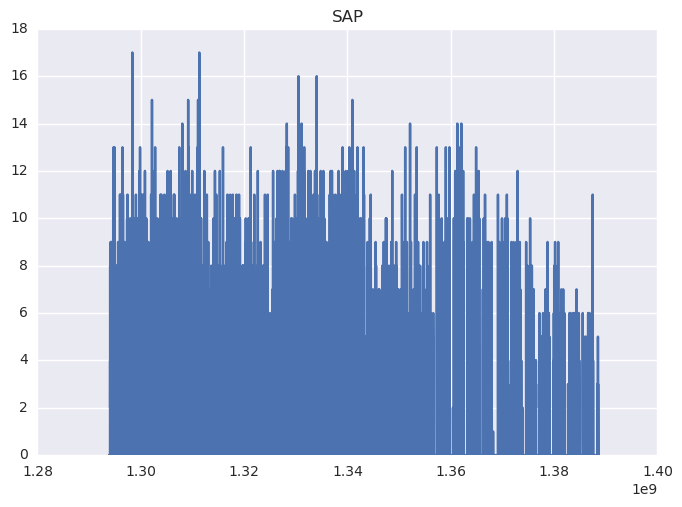

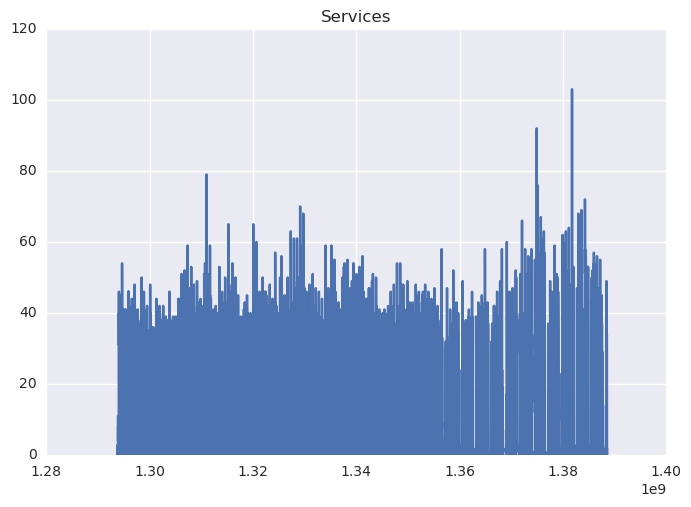

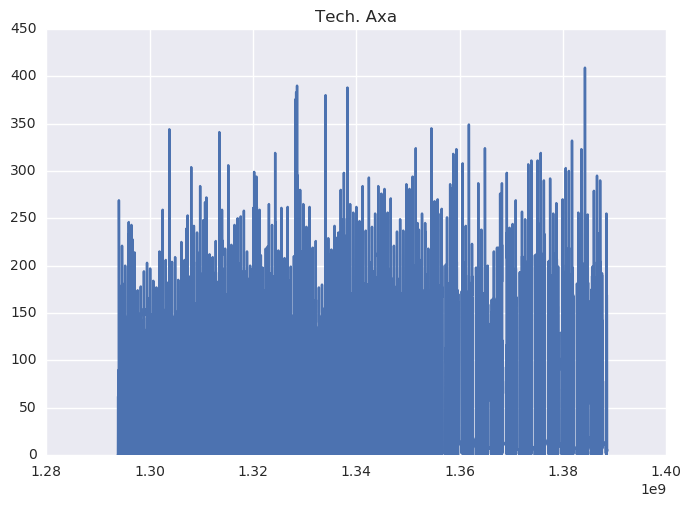

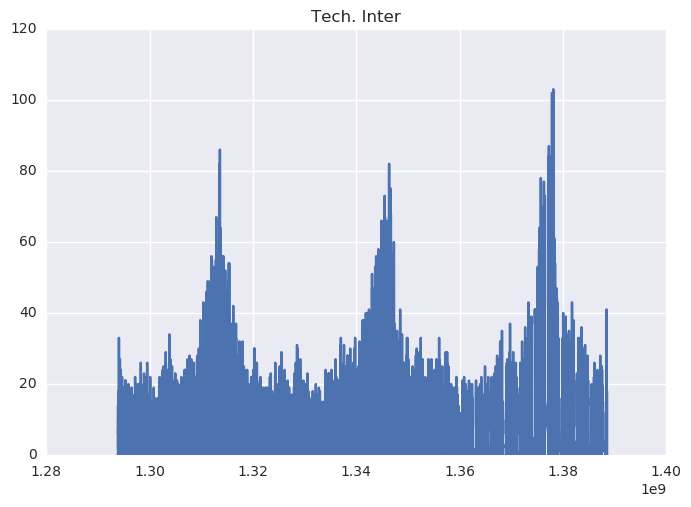

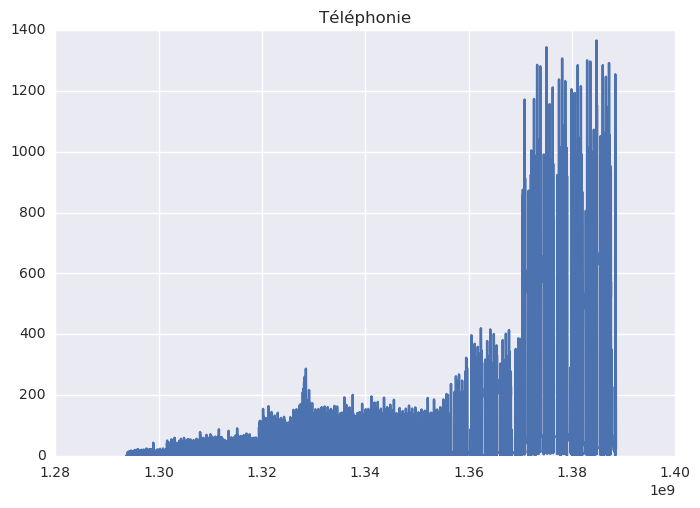

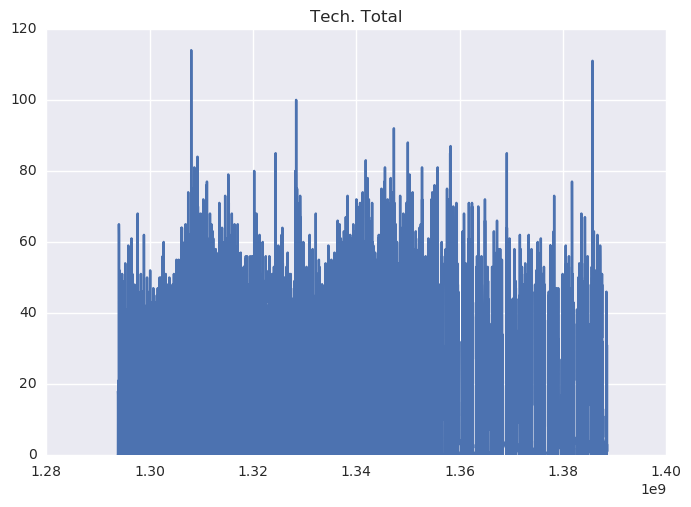

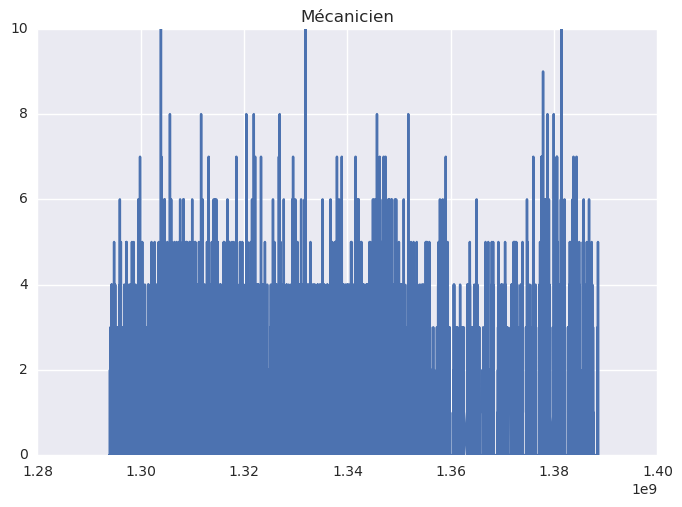

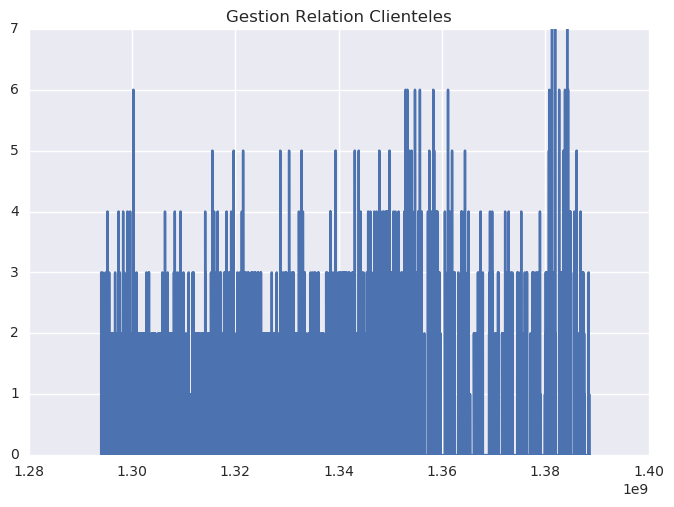

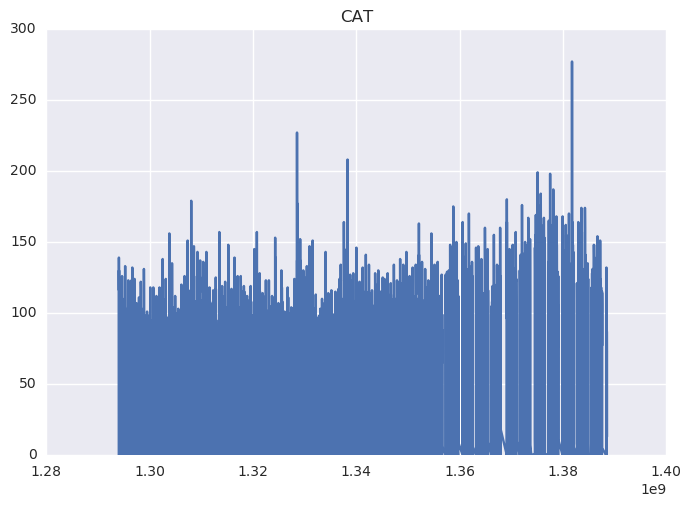

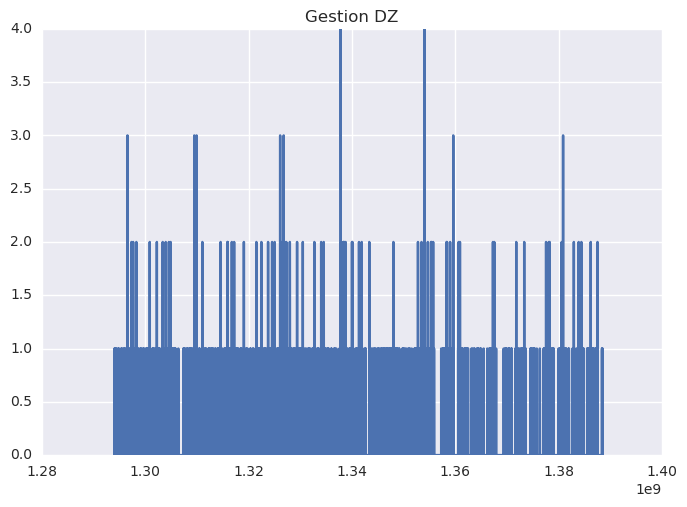

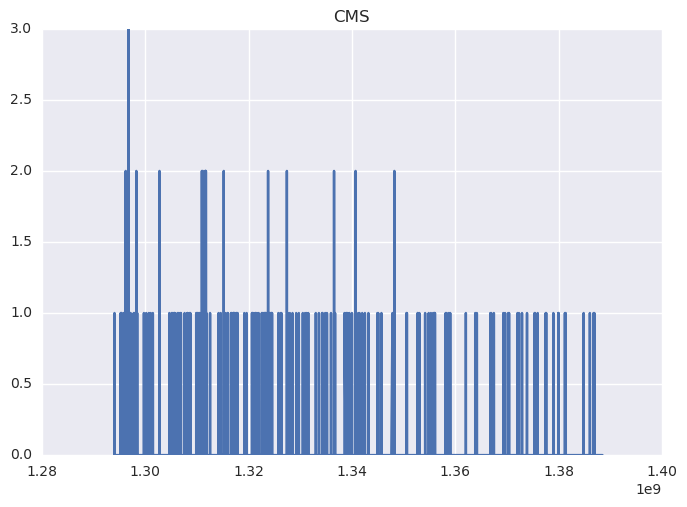

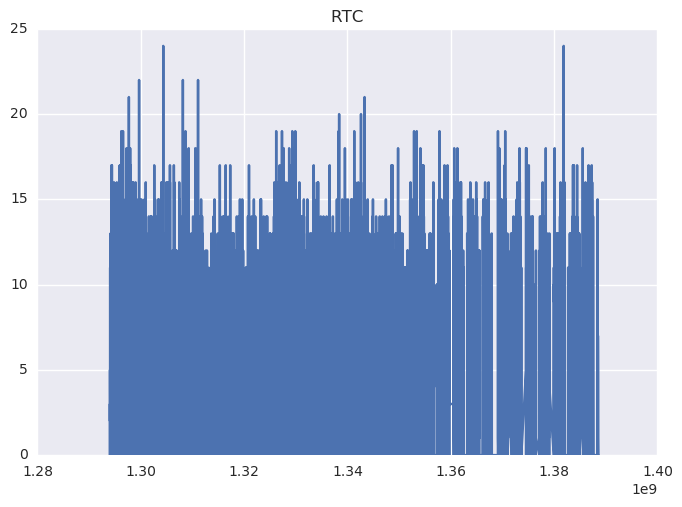

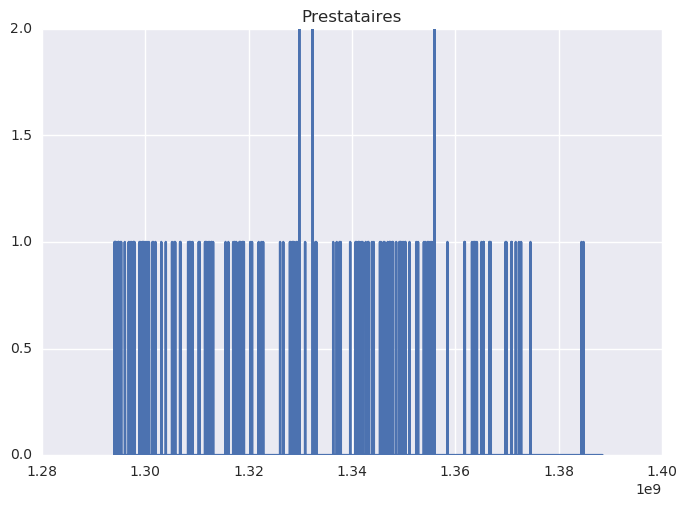

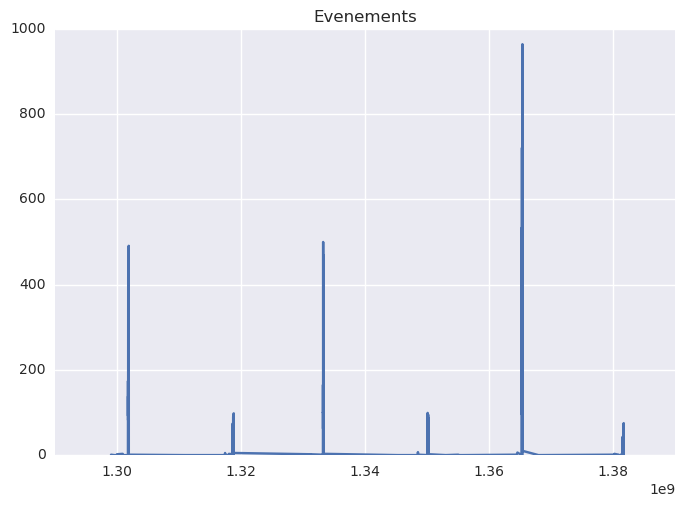

In [125]:
m = data['time_absolut'].max()
for cat in cats:
    data_cat = data[data['ASS_ASSIGNMENT'] == cat]
    day = 15
#     data_cat = data_cat[data_cat['hours'] == day]
#     data_cat = data_cat[data_cat['time_absolut'] > m - 60*60*24*28]
#     grouped = data_cat.groupby(['hours'])['CSPL_RECEIVED_CALLS'].mean()
    plt.plot(data_cat['time_absolut'],data_cat['CSPL_RECEIVED_CALLS'])
    plt.title(cat)
    plt.show()

In [291]:
data_cat = data[data['ASS_ASSIGNMENT'] == 'Crises']
# data_cat = data_cat[data_cat['time_absolut'] > m - 60*60*24*360]
#data_cat['CSPL_RECEIVED_CALLS']

/home/alogins/.local/lib/python3.4/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


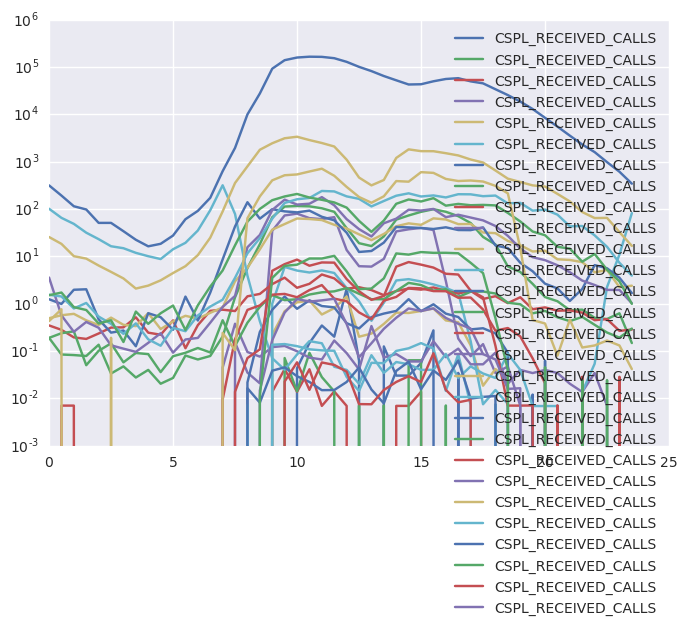

In [78]:
for cat in cats:
    plt.gca().set_yscale("log", nonposy='clip')
    data_cat = data[data['ASS_ASSIGNMENT'] == cat]
    day = 1
    data_cat = data_cat[data_cat['day_week'] == day]
    grouped = data_cat.groupby(['hours'])['CSPL_RECEIVED_CALLS'].var()
    plt.plot(grouped)
    plt.legend()

Берем последние N значений, потому что для записей, где значений очень много - там бессмысленно брать значения аля год назад, потому что надо предсказать всего на неделю, а данных - за 3 года. тренды в некоторых (я посмотрел) совершенно отличаются в последний год, что может портить статистику.

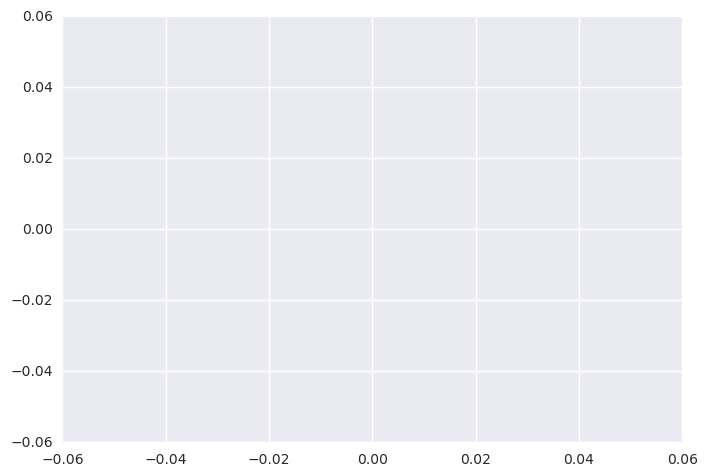

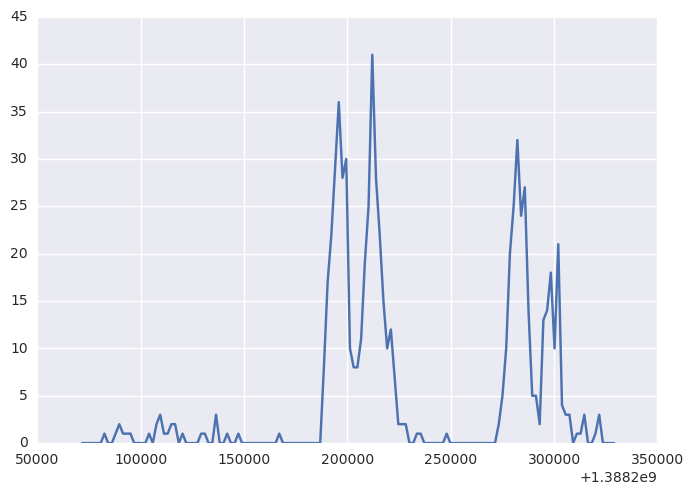

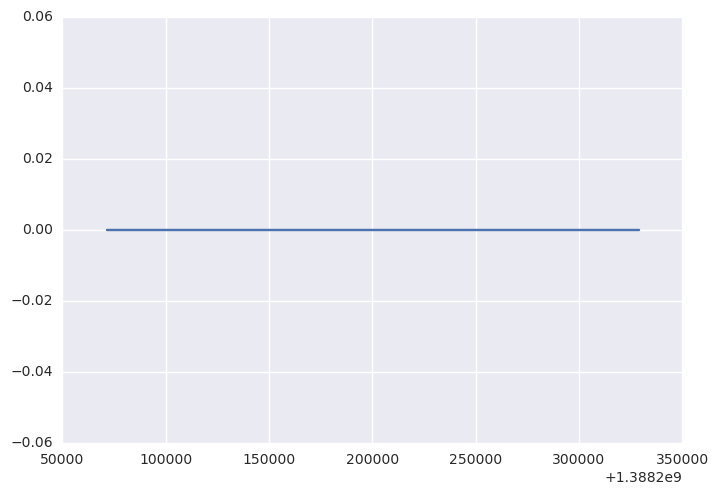

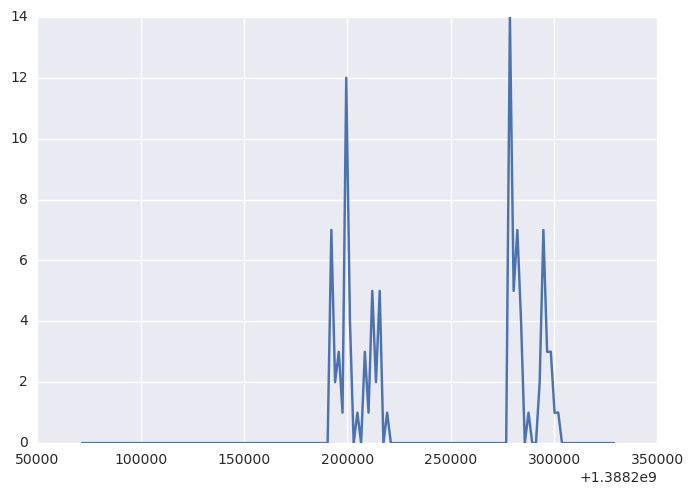

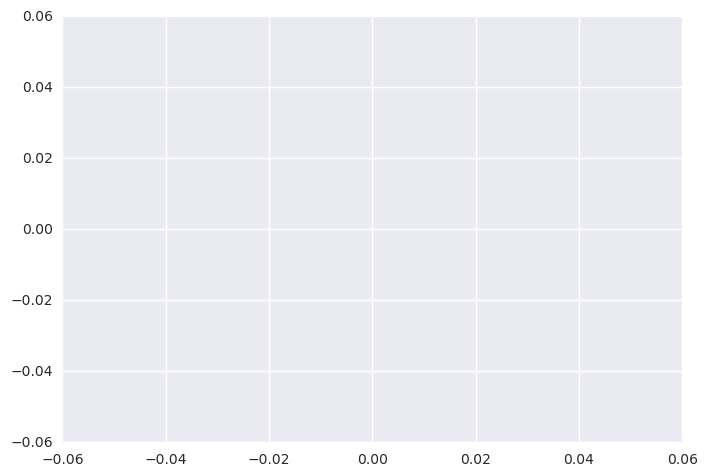

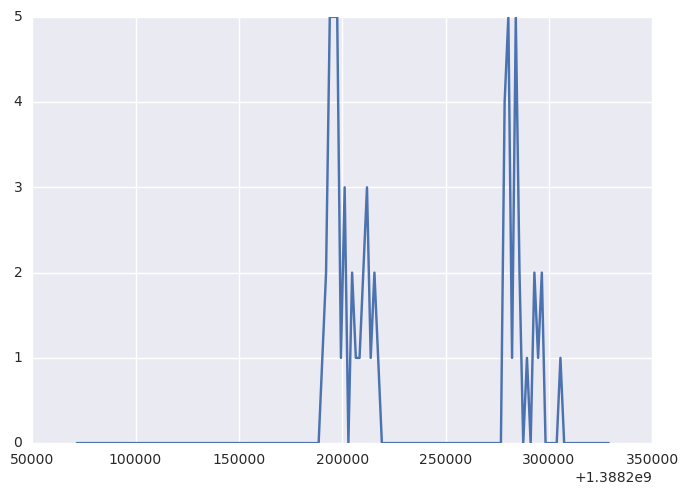

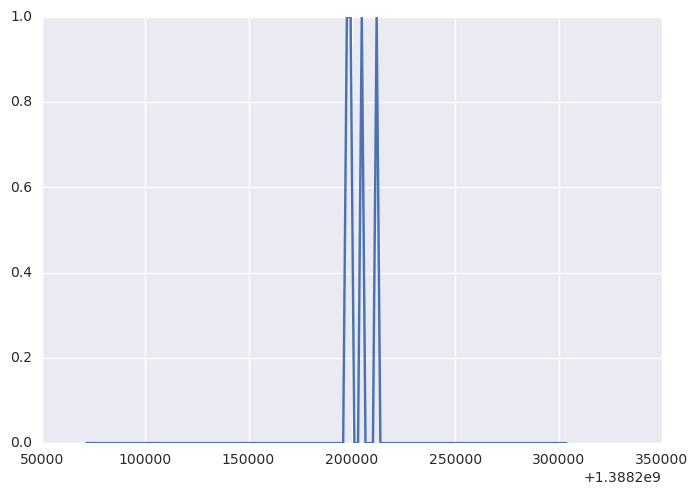

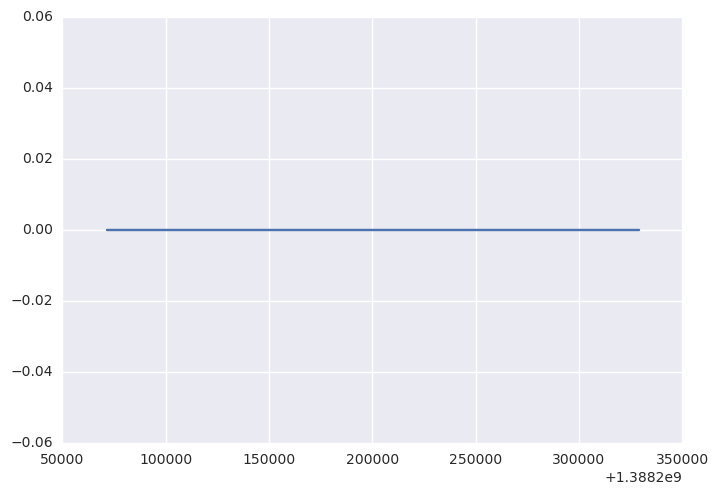

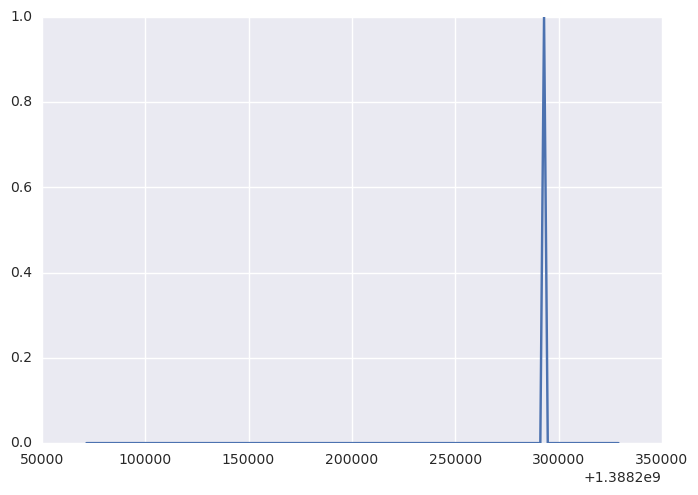

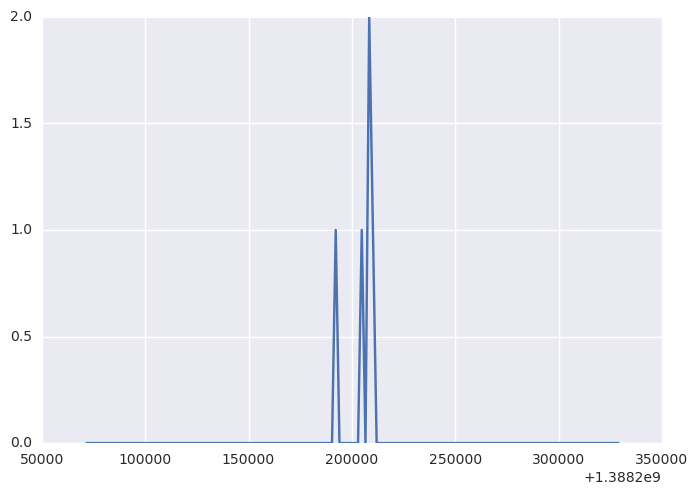

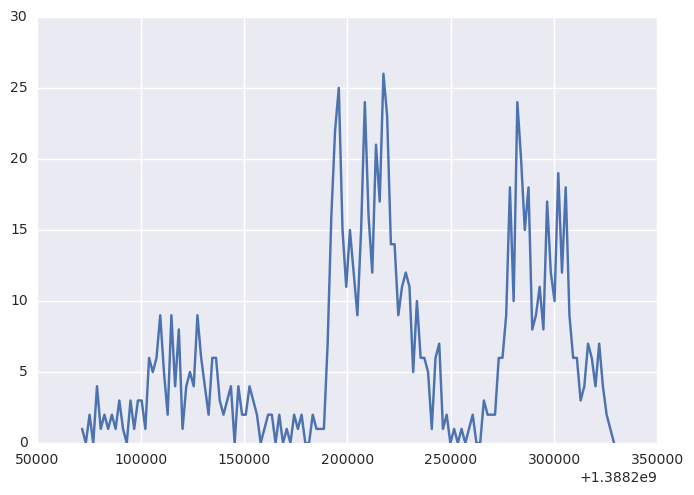

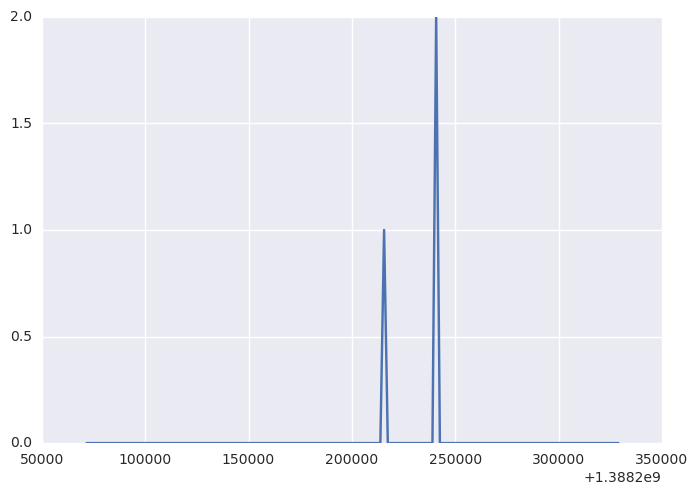

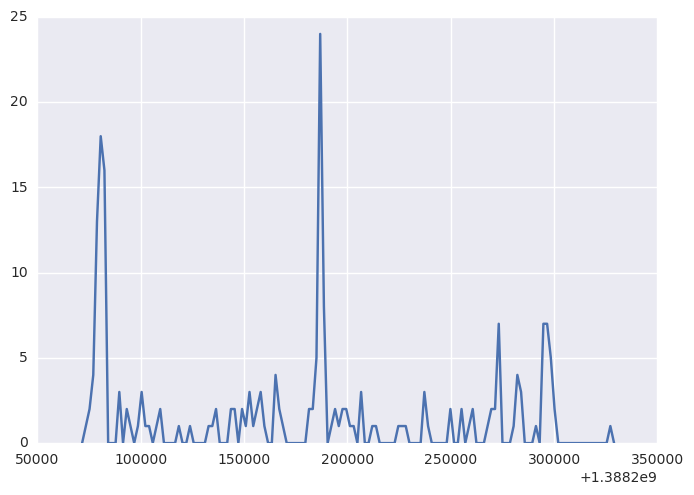

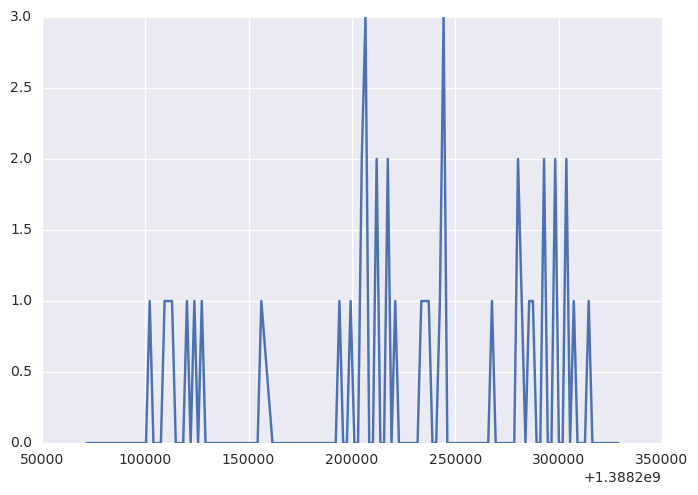

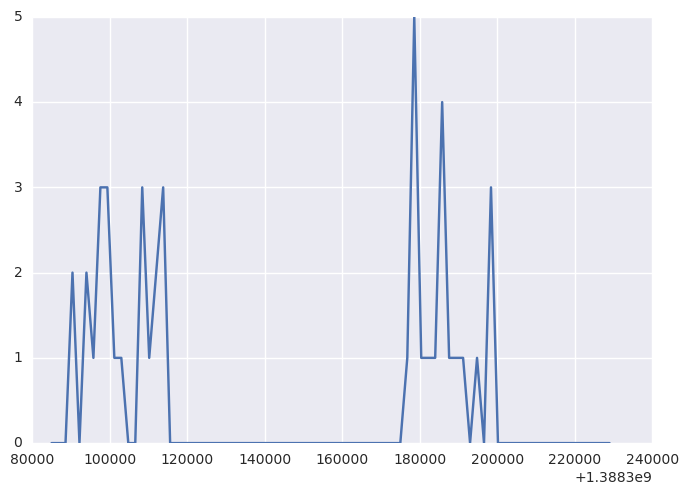

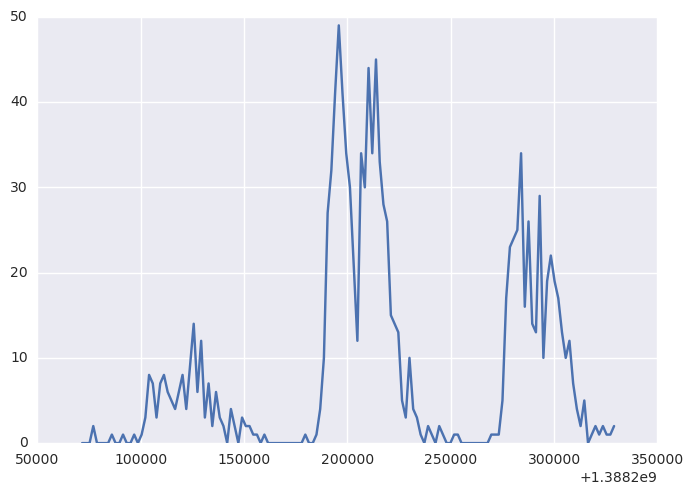

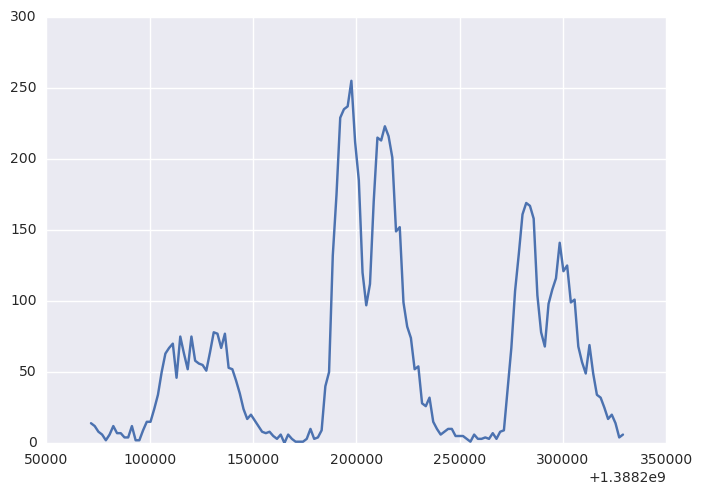

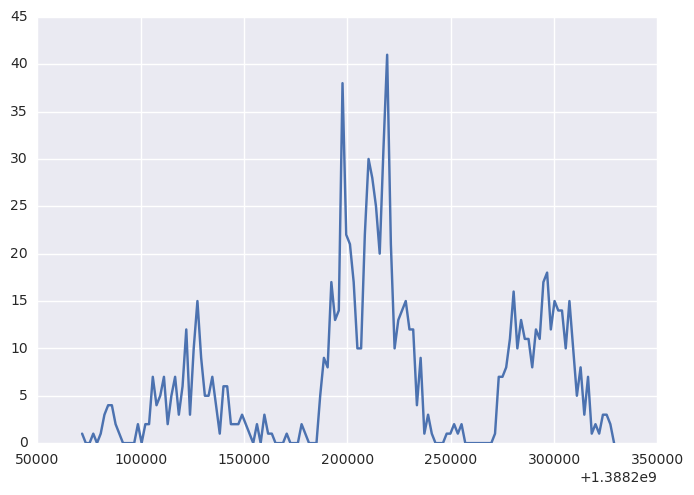

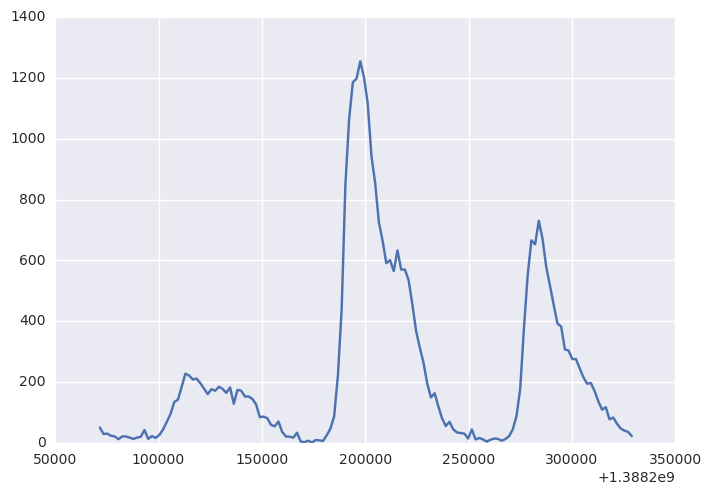

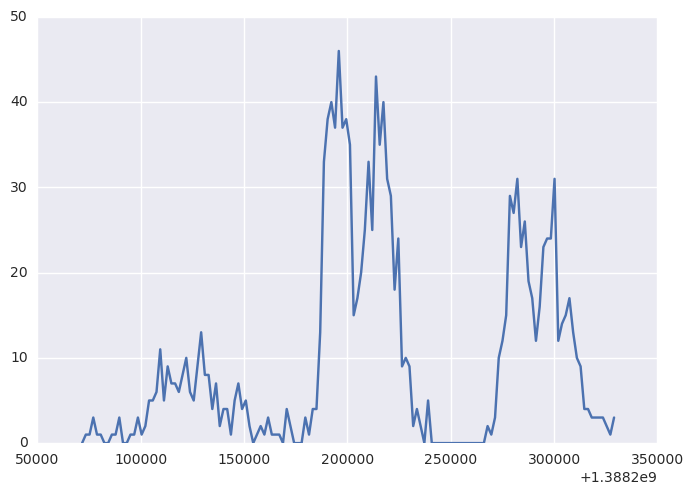

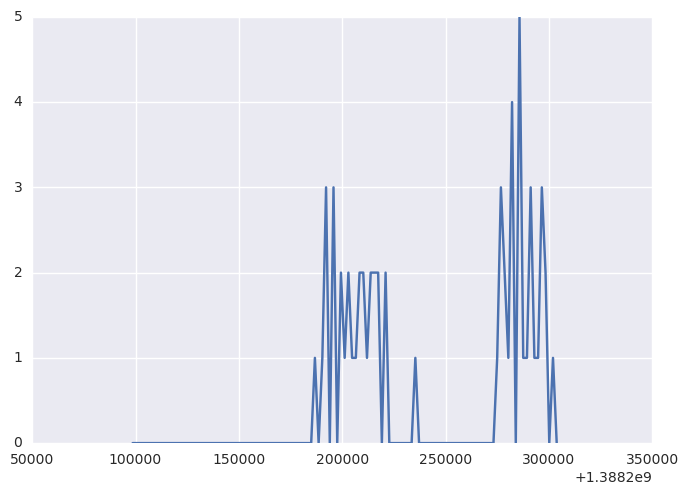

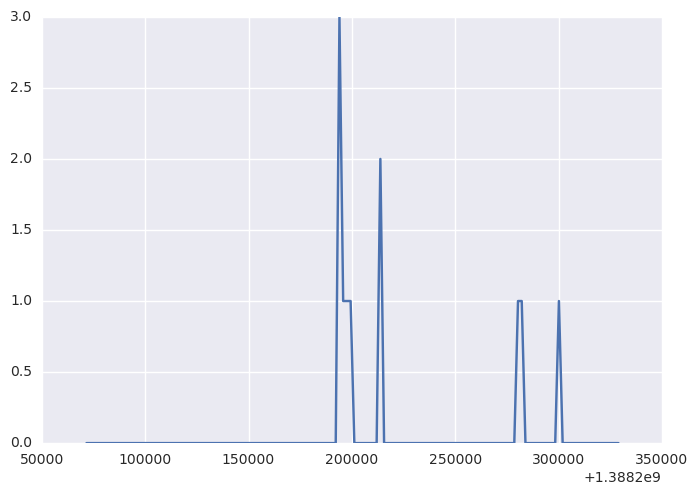

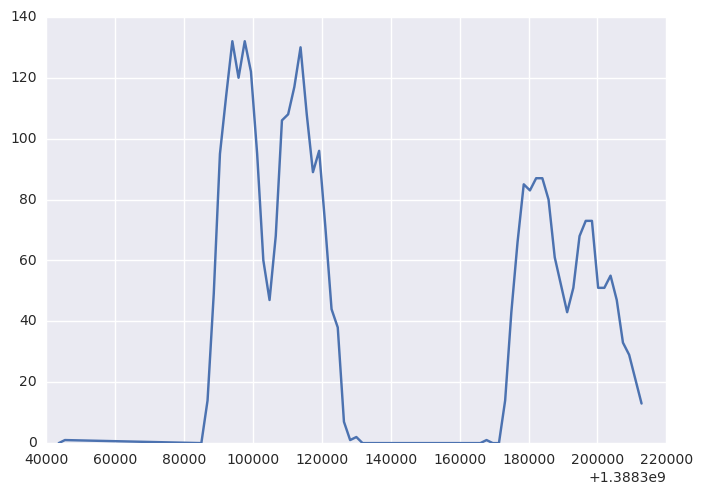

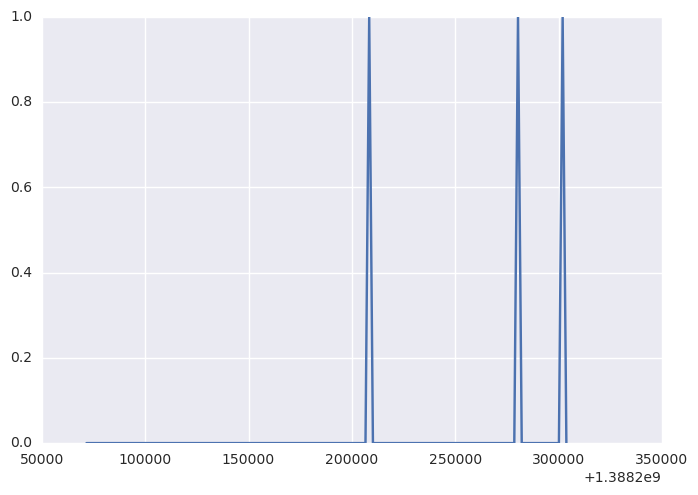

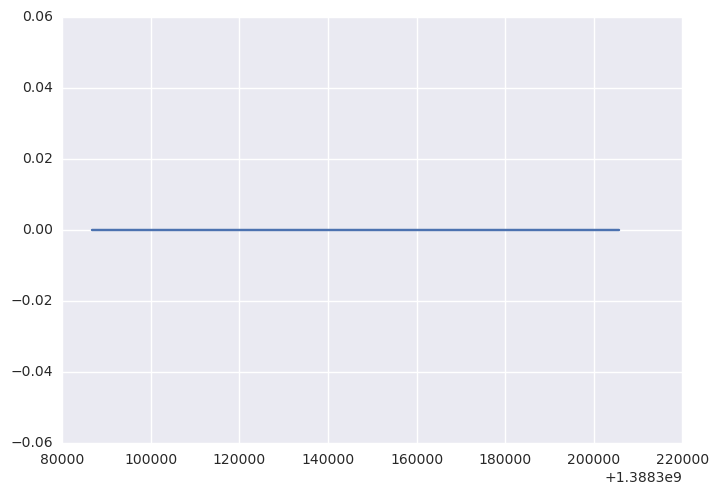

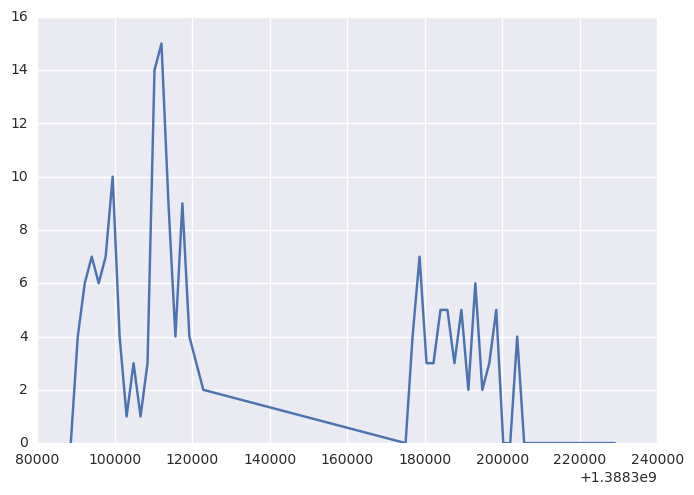

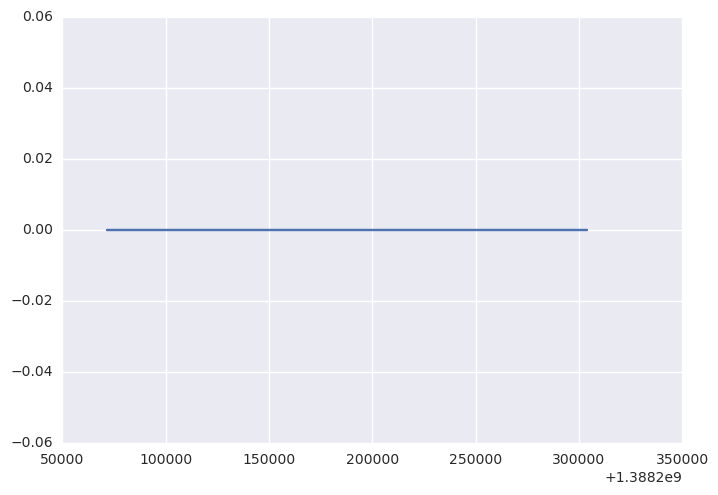

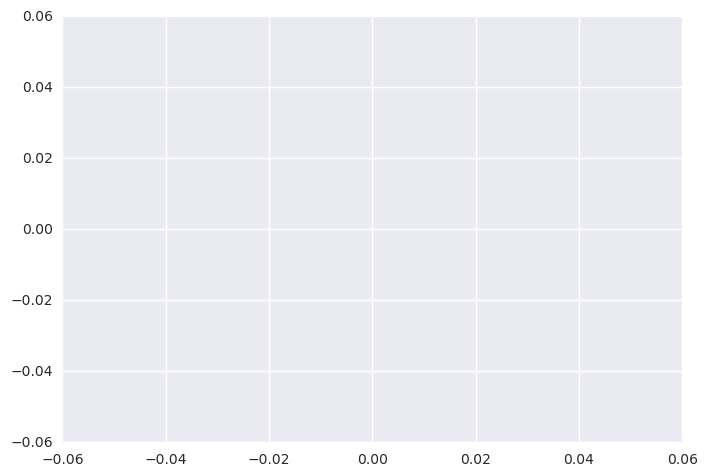

In [94]:
m = data['time_absolut'].max()
for cat in cats:
    data_cat = data[data['ASS_ASSIGNMENT'] == cat]
    day = 15
    data_cat = data_cat[data_cat['time_absolut'] > m - 60*60*24*10]
#     grouped = data_cat.groupby(['hours'])['CSPL_RECEIVED_CALLS'].mean()
    plt.plot(data_cat['time_absolut'],data_cat['CSPL_RECEIVED_CALLS'])
    plt.show()

In [53]:
subm_data['ASS_ASSIGNMENT'].unique()

array(['CMS', 'Crises', 'Domicile', 'Gestion',
       'Gestion - Accueil Telephonique', 'Gestion Assurances',
       'Gestion Relation Clienteles', 'Gestion Renault', 'Japon',
       'Médical', 'Nuit', 'RENAULT', 'Regulation Medicale', 'SAP',
       'Services', 'Tech. Axa', 'Tech. Inter', 'Téléphonie', 'Tech. Total',
       'Mécanicien', 'CAT', 'Manager', 'Gestion Clients', 'Gestion DZ',
       'RTC', 'Prestataires'], dtype=object)

 ----- skip ------

In [17]:
data['year_week'] = data['time'].apply(lambda x: time.strftime("%Y+%U", x))

In [18]:
#data_cat = data[data['ASS_ASSIGNMENT'] ==  'Prestataires']

-------- go on ---

In [22]:
not_num = ['day_week','month']
for c in not_num:
    data[c] = pd.to_numeric(data[c])

In [23]:
def eval_metric(y_pred, y_true):
    return np.exp(-0.1*(y_true-y_pred)) + 0.1*(y_true-y_pred) - 1

In [49]:
category1 = np.array(['CMS', 'Crises', 'Domicile', 'Gestion',
       'Gestion - Accueil Telephonique', 'Gestion Assurances',
       'Gestion Relation Clienteles', 'Gestion Renault', 'Japon',
       'Médical', 'Nuit', 'RENAULT', 'Regulation Medicale', 'SAP',
       'Services', 'Tech. Inter', 'Tech. Total',
       'Mécanicien', 'Manager', 'Gestion Clients', 'Gestion DZ',
       'RTC', 'Prestataires', 'CAT', 'Tech. Axa'], dtype=object)

category2 = np.array(['Téléphonie'], dtype=object)

---обработка первой категории

In [52]:
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.cross_validation import train_test_split

model_main = {}
model_metric = {}
model_index = {}
for cat in category1:
    data_cat = data[data['ASS_ASSIGNMENT'] == cat]
    indexes = ['day_week','month','time_absolut','hours','if_weekend','if_night']
    dummies = ['day_week', 'month', 'ASS_ASSIGNMENT']
    
    for d in dummies:
        data_cat = pd.concat((data_cat, pd.get_dummies(data_cat[d])),axis=1)
        for val in data_cat[d].unique():
            indexes.append(val)
    
    X = data_cat[indexes]
    Y = data_cat['CSPL_RECEIVED_CALLS']
    X_train, X_test, y_train, y_test = train_test_split(X,Y)
    model = rf()
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    pred = np.round(pred)
    metric = np.mean(eval_metric(pred, y_test))
    model_main[cat] = model
    model_metric[cat] = metric 
    model_index[cat] = indexes
    

In [48]:
model_metric

{'CAT': 13.027515297517718,
 'CMS': 8.905802530743701e-05,
 'Crises': 0.0002454870073662757,
 'Domicile': 0.09684697069551595,
 'Gestion': 1.9592410773158748e-05,
 'Gestion - Accueil Telephonique': 0.030465947182911436,
 'Gestion Assurances': 0.004532503855394317,
 'Gestion Clients': 0.0017900254625901376,
 'Gestion DZ': 0.00027918476114609697,
 'Gestion Relation Clienteles': 0.0016253627260065548,
 'Gestion Renault': 1.1663759849772807e-05,
 'Japon': 0.0061571053553133625,
 'Manager': 0.0003073373116118103,
 'Mécanicien': 0.005226344462946661,
 'Médical': 0.07529923335327128,
 'Nuit': 0.0851539488818433,
 'Prestataires': 0.00011250663094982904,
 'RENAULT': 0.05949697764606851,
 'RTC': 0.03232242341875336,
 'Regulation Medicale': 0.0052120222354030965,
 'SAP': 0.007139882680402476,
 'Services': 0.11646790406403794,
 'Tech. Axa': 806.664028140577,
 'Tech. Inter': 0.08213117400635593,
 'Tech. Total': 0.22706191442257642}

---обработка второй категории

In [26]:
def get_result2(x):
    cat = x['ASS_ASSIGNMENT']
    data_cat = data[data['ASS_ASSIGNMENT'] == cat]
    tel_data = data_cat   
    res = tel_data.query('year == @x.year & month >= @x.month-1 & month <= @x.month+1 & hours == @x.hours')
    assert(len(res) > 0)
    return res['CSPL_RECEIVED_CALLS'].mean()

---работа с сабмишен

In [27]:
subm_data = pd.read_table('submission.txt')

In [28]:
subm_data['time'] = subm_data['DATE'].apply(lambda x: time.strptime(x, '%Y-%m-%d %H:%M:%S.000'))
subm_data['day_week'] = subm_data['time'].apply(lambda x: int(time.strftime("%w", x)))
subm_data['day_month'] = subm_data['time'].apply(lambda x: int(time.strftime("%d", x)))
subm_data['month'] = subm_data['time'].apply(lambda x: int(time.strftime("%m", x)))
subm_data['time_absolut'] = subm_data['time'].apply(time.mktime)
subm_data['hours'] = subm_data['time'].apply(lambda x: float(time.strftime("%H", x)))
subm_data['year'] = subm_data['time'].apply(lambda x: float(time.strftime("%Y", x)))
subm_data['if_weekend'] = subm_data['day_week'].apply(lambda x: 1 if x == 0 or x == 6 else 0)
subm_data['if_night'] = subm_data['hours'].apply(lambda x: 1 if x >= 7.5 and x <= 23.5 else 0) 

not_num = ['day_week','month']
for c in not_num:
    subm_data[c] = pd.to_numeric(subm_data[c])


In [29]:
for d in dummies:
    subm_data = pd.concat((subm_data, pd.get_dummies(subm_data[d])),axis=1)

In [30]:
X = subm_data

In [31]:
def mach_cat1(x):
    p = False
    for cat in category1 :
        if x['ASS_ASSIGNMENT'] == cat :
            return True
    return False

In [32]:
def get_result(t) :
    if mach_cat1(t) == True :
        key = t['ASS_ASSIGNMENT']
        index = model_index[key]
        model = model_main[key]
        return model.predict(t[index])
    else:
        return get_result2(t)

In [33]:
all_indexes = set()
for key in model_index:
    for ind in model_index[key]:
        all_indexes.add(ind)
for key in all_indexes:
    if key not in subm_data.columns:
        subm_data[key] = 0

In [34]:
X = subm_data

In [ ]:
X['prediction'] = X.apply(get_result, axis=1)
X['prediction'] = X['prediction'].apply(np.round)

C:\Users\Irina\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Irina\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Irina\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning

In [38]:
X['prediction'] = X['prediction'].apply(int)

In [40]:
import csv
base_filename = 'submission1.csv'
X[['prediction']].to_csv(base_filename, sep=' ', index=False, quoting=None)

In [41]:
model_metric

{'CAT': 7.09644339202775,
 'CMS': 0.00010490529713334674,
 'Crises': 8.497937798584822e-05,
 'Domicile': 0.10536718607593482,
 'Gestion': 2.340738603941395e-05,
 'Gestion - Accueil Telephonique': 0.029516148114510372,
 'Gestion Assurances': 0.0043824452100703,
 'Gestion Clients': 0.0018626627382360332,
 'Gestion DZ': 0.00028192673541811285,
 'Gestion Relation Clienteles': 0.0015708806771682338,
 'Gestion Renault': 2.1177866870698532e-05,
 'Japon': 0.005976161306665043,
 'Manager': 0.0003591792000981839,
 'Mécanicien': 0.0052578623730526585,
 'Médical': 0.074411228663566,
 'Nuit': 0.08512139671096114,
 'Prestataires': 0.00010515024219383592,
 'RENAULT': 0.06102716990633392,
 'RTC': 0.03311322844583023,
 'Regulation Medicale': 0.0051752731254365554,
 'SAP': 0.007358885632798162,
 'Services': 0.11902755518490535,
 'Tech. Axa': 132.82877628688388,
 'Tech. Inter': 0.07886505433306788,
 'Tech. Total': 0.22653279254468056}

In [143]:
subm_data = pd.read_table('submission_best.txt')

In [145]:
import csv
base_filename = 'submission1.csv'
subm_data[['prediction']].to_csv(base_filename, sep=' ', index=False, quoting=None)

PermissionError: [Errno 13] Permission denied: 'submission1.csv'

In [180]:
moyen = pd.DataFrame(data.groupby(['ASS_ASSIGNMENT'])['CSPL_RECEIVED_CALLS'].sum()/(365*48))
moyen.reset_index(level=0, inplace=True)
moyen.reset_index(level=0, inplace=True)

In [181]:
moyen['CSPL_RECEIVED_CALLS'] = moyen['CSPL_RECEIVED_CALLS'].apply(np.ceil).apply(int)*2


In [182]:
data1 = subm_data.merge(moyen,on=['ASS_ASSIGNMENT'],how ='left',sort=False)

In [183]:
data1

﻿DATE                  ASS_ASSIGNMENT  prediction  \
0      2012-12-28 00:00:00.000                             CMS           0   
1      2012-12-28 00:00:00.000                          Crises           0   
2      2012-12-28 00:00:00.000                        Domicile           0   
3      2012-12-28 00:00:00.000                         Gestion           0   
4      2012-12-28 00:00:00.000  Gestion - Accueil Telephonique           0   
5      2012-12-28 00:00:00.000              Gestion Assurances           0   
6      2012-12-28 00:00:00.000     Gestion Relation Clienteles           0   
7      2012-12-28 00:00:00.000                 Gestion Renault           0   
8      2012-12-28 00:00:00.000                           Japon           0   
9      2012-12-28 00:00:00.000                         Médical           0   
10     2012-12-28 00:00:00.000                            Nuit          16   
11     2012-12-28 00:00:00.000                         RENAULT           0   
12     2012-12-28 00:00:00.000             Regulation Medicale           0   
13     2012-12-28 00:00:00.000                             SAP           0   
14     2012-12-28 00:00:00.000                        Services           1   
15     2012-12-28 00:00:00.000                       Tech. Axa           0   
16     2012-12-28 00:00:00.000                     Tech. Inter           0   
17     2012-12-28 00:00:00.000                      Téléphonie           5   
18     2012-12-28 00:30:00.000                             CMS           0   
19     2012-12-28 00:30:00.000                          Crises           0   
20     2012-12-28 00:30:00.000                        Domicile           0   
21     2012-12-28 00:30:00.000                         Gestion           0   
22     2012-12-28 00:30:00.000  Gestion - Accueil Telephonique           0   
23     2012-12-28 00:30:00.000              Gestion Assurances           0   
24     2012-12-28 00:30:00.000     Gestion Relation Clienteles           0   
25     2012-12-28 00:30:00.000                 Gestion Renault           0   
26     2012-12-28 00:30:00.000                           Japon           0   
27     2012-12-28 00:30:00.000                         Médical           0   
28     2012-12-28 00:30:00.000                            Nuit          17   
29     2012-12-28 00:30:00.000                         RENAULT           0   
...                        ...                             ...         ...   
82879  2013-12-28 23:00:00.000                         Médical           1   
82880  2013-12-28 23:00:00.000                            Nuit           1   
82881  2013-12-28 23:00:00.000                    Prestataires           0   
82882  2013-12-28 23:00:00.000                         RENAULT           1   
82883  2013-12-28 23:00:00.000             Regulation Medicale           0   
82884  2013-12-28 23:00:00.000                        Services           3   
82885  2013-12-28 23:00:00.000                       Tech. Axa          16   
82886  2013-12-28 23:00:00.000                     Tech. Inter           2   
82887  2013-12-28 23:00:00.000                     Tech. Total           0   
82888  2013-12-28 23:00:00.000                      Téléphonie          52   
82889  2013-12-28 23:30:00.000                        Domicile           0   
82890  2013-12-28 23:30:00.000                         Gestion           0   
82891  2013-12-28 23:30:00.000  Gestion - Accueil Telephonique           0   
82892  2013-12-28 23:30:00.000              Gestion Assurances           0   
82893  2013-12-28 23:30:00.000                 Gestion Clients           0   
82894  2013-12-28 23:30:00.000                      Gestion DZ           0   
82895  2013-12-28 23:30:00.000     Gestion Relation Clienteles           0   
82896  2013-12-28 23:30:00.000                 Gestion Renault           0   
82897  2013-12-28 23:30:00.000                           Japon           0   
82898  2013-12-28 23:30:00.000                 

In [184]:
import csv
base_filename = 'submission1.csv'
data1[['CSPL_RECEIVED_CALLS']].to_csv(base_filename, sep=' ', index=False, quoting=None)